In [219]:
from networkit.graph import Graph
import networkit as nk
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html

def get_random_node_uniform(a_huge_key_list):
    L = len(a_huge_key_list)
    i = np.random.randint(0, L)
    return a_huge_key_list[i]

def opinion_diff(u, v, att):
    
    return att[u] - att[v]


def update_opinions(u, v, att, convergence, symmetric_updating=True):
    diff = opinion_diff(u, v, att)
    att[u] -= convergence * diff
    
    if symmetric_updating:
        att[v] += convergence * diff
    return 

        
def update_effective_net(u, v, effective_net, G, att, threshold, symmetric_updating):
    # update u's neighbors
    for w in G.iterNeighbors(u):
        diff = abs(opinion_diff(u, w, att))
        
        if diff <= threshold and not effective_net.hasEdge(u, w):
            effective_net.addEdge(u, w)

        elif diff > threshold and effective_net.hasEdge(u, w):
            effective_net.removeEdge(u, w)
        
    if not symmetric_updating:
        return effective_net
    
    # update v's neighbors
    for w in G.iterNeighbors(v):
        diff = abs(opinion_diff(v, w, att))
        
        if diff <= threshold and not effective_net.hasEdge(v, w):
            effective_net.addEdge(v, w)

        elif diff > threshold and effective_net.hasEdge(v, w):
            effective_net.removeEdge(v, w)
    return effective_net


def simulate_deffuant_model(G: nk.graph.Graph, iterations: int, threshold: float,\
                            convergence: float, symmetric_updating=True, fast_mode=False):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize node attributes
    att = G.attachNodeAttribute("opinion", float)
    for node in G.iterNodes():
            att[node] = np.random.uniform(0, 1)

    # get initial effective network
    effective_net = copy.deepcopy(G)
    
    # remove edges between nodes with opinion difference above threshold
    for u, v in effective_net.iterEdges():
        if abs(opinion_diff(u, v, att)) > threshold:
            effective_net.removeEdge(u, v)

    if not fast_mode:
        # initialize the list of nets that will be returned
        effective_networks = [(effective_net,att)]
    # run simulation
    for t in np.arange(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = copy.deepcopy(effective_net)
        
        # choose random node to update
        u = np.random.randint(0, G.numberOfNodes())
        
        # get another node if u is isolated
        while effective_net.degree(u) == 0:
            u = np.random.randint(0, G.numberOfNodes())
        
        # get a random neighbor of u
        v = get_random_node_uniform(np.fromiter(G.iterNeighbors(u), np.int_))
        # update their opinions
        
        update_opinions(u, v, att, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, G, att, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            effective_networks.append((effective_net, att))
    
    if not fast_mode:
        return effective_networks
    else:
        return effective_net

In [199]:
from networkit.components import ConnectedComponents

# metrics functions

# equation 3 in the paper
def dispersion_index(G):
    cc = ConnectedComponents(G)
    cc.run()
    return sum([len(cluster)**2 for cluster in cc.getComponents()])/(G.numberOfNodes()**2)

def network_modularity(G):
    cc = ConnectedComponents(G)
    cc.run()
    return sum([len(cluster)**2 for cluster in cc.getComponents()])/(G.numberOfNodes()**2)

def avg_dispersion_data(case, order, iterations, sample_size, points, init_d, final_d, convergence):
    avg_dispersions = [0 for i in range(points)]
    d = [init_d + i*(final_d-init_d)/points for i in range(points)]
    
    for i in range(points):
        print(".", end='')
        for j in range(sample_size):
            
            # generate network sample
            if case == 'scale_free':
                net = nx.barabasi_albert_graph(n=order, m=2, initial_graph=nx.complete_graph(3))
                net = nk.nxadapter.nx2nk(net, weightAttr=None)
            elif case == 'complete_mixing':
                net = nx.complete_graph(n=order)
                net = nk.nxadapter.nx2nk(net, weightAttr=None)
            elif case == 'lattice':
                net = nx.grid_2d_graph(int(np.sqrt(order)), int(np.sqrt(order)), periodic=False)
                net = nk.nxadapter.nx2nk(net, weightAttr=None)
            else:
                return None

            final_net = simulate_deffuant_model(net, iterations, d[i], convergence, fast_mode=True)
            avg_dispersions[i] += dispersion_index(final_net)
    
    print()
    avg_dispersions = [dispersion_sum/sample_size for dispersion_sum in avg_dispersions]
        
    return d, avg_dispersions

In [200]:
#plt.style.use('_mpl-gallery')

# data
x_sf, y_sf = avg_dispersion_data('scale_free', order=900, iterations=10000, sample_size=20,\
                           points=25, init_d=0.1, final_d=0.6, convergence=0.3)

# x_cm, y_cm = avg_dispersion_data('complete_mixing', order=900, iterations=10000, sample_size=20,\
#                            points=25, init_d=0.1, final_d=0.6, convergence=0.3)



.........................


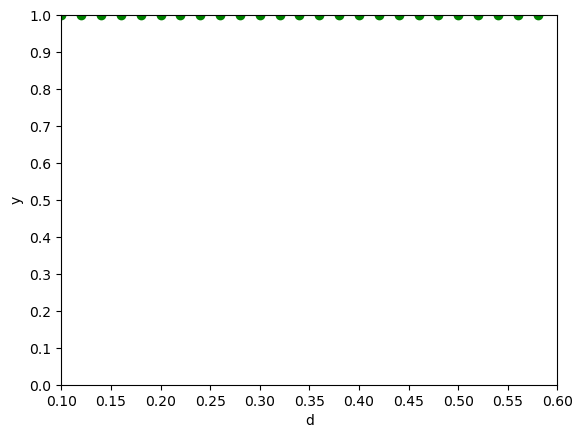

In [201]:
# plot
fig, ax = plt.subplots()

ax.scatter(x_sf, y_sf, color="g")
#ax.scatter(x_cm, y_cm, color="r")

ax.set_ylabel("y")
ax.set_ylim([0,1])
ax.set_yticks(np.linspace(0,1,11))
ax.set_xlabel("d")
ax.set_xlim([0.1,0.6])
ax.set_xticks(np.linspace(0.1,0.6,11))

plt.show()

In [ ]:
# data
x_sf, y_sf = avg_dispersion_data('scale_free', order=900, iterations=1000, sample_size=1,\
                           points=25, init_d=0.1, final_d=0.3, convergence=0.3)

x_cm, y_cm = avg_dispersion_data('complete_mixing', order=900, iterations=1000, sample_size=1,\
                           points=25, init_d=0.1, final_d=0.3, convergence=0.3)



In [247]:
# we set n=900 in the BA graph so that it has the same amount of vertices as the 30x30 grid graph
# we set m=2 so that the average degree of the graph is 2*|E|/n = 2*(3+2*897)/900 ~= 4 as in the grid graph

BA_graph = nx.barabasi_albert_graph(n=900, m=2, seed=42, initial_graph=nx.complete_graph(3))
lattice  = nx.grid_2d_graph(30, 30, periodic=False, create_using=None)

complete = nx.complete_graph(n=900)
complete = nk.nxadapter.nx2nk(complete, weightAttr=None)

BA_graph = nk.nxadapter.nx2nk(BA_graph, weightAttr=None)
lattice = nk.nxadapter.nx2nk(lattice, weightAttr=None)

In [228]:
start_ = time.time()

effective_networks = simulate_deffuant_model(complete, 10000, 0.3, 0.3, fast_mode=True)

total_time = round(time.time()-start_, 3)
print(f"simulation time: {total_time} seconds")

simulating took 20.458078384399414 seconds
simulation time: 21.723 seconds


In [11]:
plmCommunities = nk.community.detectCommunities(BA_graph, algo=nk.community.PLM(BA_graph, True))
nk.community.Modularity().getQuality(plmCommunities, BA_graph)

Communities detected in 0.11741 [s]
solution properties:
-------------------  ----------
# communities         18
min community size    23
max community size    74
avg. community size   50
imbalance              1.48
edge cut             718
edge cut (portion)     0.399555
modularity             0.534553
-------------------  ----------


0.5345531986316153

In [292]:
from networkit.algebraic import adjacencyMatrix

total_time = 0
n = 1
att = np.random.uniform(0, 1, size = complete.numberOfNodes())
for _ in range(n):
    adj = adjacencyMatrix(complete, "dense")
    start = time.time()
    nx.from_numpy_array(adj)
    total_time += time.time()-start
total_time = round(total_time, 12)
print(f"simulation time: {total_time} seconds")

simulation time: 1.986965179443 seconds


In [271]:
total_time = 0
n = 1000
t_1 = 0
t_2 = 0

eff_net = copy.deepcopy(complete)

att = np.random.uniform(0, 1, size = complete.numberOfNodes())
for _ in range(n):
    
    print(_)
    start_1 = time.time()

    neigh = np.fromiter(complete.iterNeighbors(0), np.int_)
    diff = (abs(att[neigh] - att[0])<0.3)
    eff_edges = np.fromiter(map(lambda w: eff_net.hasEdge(0, w) , neigh), np.bool_)
    add_updates = diff & ~eff_edges
    delete_updates = ~diff & eff_edges
    
    t_1 += time.time()-start_1


    start_2 = time.time()
    [eff_net.addEdge(0, w) for w in add_updates[neigh].nonzero()[0]]
    [eff_net.removeEdge(0, w) for w in delete_updates[neigh].nonzero()[0]]
    t_2 += time.time()-start_2

t_1 = round(t_1, 12)
t_2 = round(t_2, 12)

print(f"simulation time: {t_1} seconds")
print(f"simulation time: {t_2} seconds")


0


IndexError: index 899 is out of bounds for axis 0 with size 899

In [288]:
eff_net = copy.deepcopy(complete)
att = np.random.uniform(0, 1, size = complete.numberOfNodes())

neigh = np.fromiter(complete.iterNeighbors(0), np.int_)

diff = (abs(att - att[0])<0.3)

eff_edges = np.fromiter(map(lambda w: eff_net.hasEdge(0, w) , complete.iterNodes()), np.bool_)
add_updates = diff & ~eff_edges
delete_updates = ~diff & eff_edges

delete_updates[]

# [eff_net.addEdge(0, w) for w in add_updates[neigh].nonzero()[0]]
# [eff_net.removeEdge(0, w) for w in delete_updates[neigh].nonzero()[0]]




array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [264]:
neigh = np.fromiter(complete.iterNeighbors(0), np.int_)
diff = (abs(att[neigh] - att[0])<0.3)

eff_edges = np.fromiter(map(lambda w: eff_net.hasEdge(0, w) , neigh), np.bool_)
add_updates = diff & ~eff_edges
add_updates.nonzero()

delete_updates = ~diff & eff_edges
delete_updates.nonzero()

[eff_net.addEdge(0, w) for w in add_updates.nonzero()[0] if w!=0]
[eff_net.removeEdge(0, w) for w in delete_updates.nonzero()[0] if w!=0]

RuntimeError: edge (0,6) does not exist

In [28]:
from networkit.graph import Graph
import pandas as pd
G = Graph(10, weighted=True)

G.addEdge(0,1)

att = np.random.uniform(0, 1, size = complete.numberOfNodes())

#adj = adjacencyMatrix(G, "dense")
#np.nonzero(adj)


neigh = list(complete.iterNeighbors(0))

(abs(att[list(complete.iterNeighbors(0))] - att[0])<0.3) & np.array(list(map(lambda w: False if G.hasEdge(0, w) else True, neigh)))


#f_l = lambda x: att[x] if(x!=0) else 0.0
#f_l_vec =  np.vectorize(f_l)

#f_l_vec(adj)

#nz = np.nonzero(adj)
#adj[nz] = np.random.uniform(0, 1)
#diff_mat = np.array(list(map(lambda x: abs(att-x), att)))
#diff_mat = (diff_mat < 0.5).astype(np.int_)
#np.multiply(diff_mat, adj)


899

In [227]:
from networkit.graph import Graph
import networkit as nk
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html
from networkit.algebraic import adjacencyMatrix
from networkit.graph import Graph
import pandas as pd


def opinion_diff(u, v, att):
    
    return att[u] - att[v]


def update_opinions(u, v, att, convergence, symmetric_updating=True):
    diff = opinion_diff(u, v, att)
    att[u] -= convergence * diff
    
    if symmetric_updating:
        att[v] += convergence * diff
    return 

        
def update_effective_net(u, v, effective_net, G, att, threshold, symmetric_updating):
    
    # update u's neighbors
    t_1 = 0
    t_2 = 0

    start_1 = time.time()

    neigh = list(G.iterNeighbors(u))
    diff = (abs(att[neigh] - att[u])<0.3)
    eff_edges = np.array(list(map(lambda w: effective_net.hasEdge(u, w) , neigh)))
    add_updates = diff & ~eff_edges
    delete_updates = ~diff & eff_edges
    
    t_1 += time.time()-start_1


    start_2 = time.time()
    [effective_net.addEdge(u, w) if add_updates[w] else None for w in neigh]
    [effective_net.removeEdge(u, w) if delete_updates[w] else None for w in neigh]
    t_2 += time.time()-start_2

    if not symmetric_updating:
        return effective_net
    
    # update v's neighbors
    neigh = list(G.iterNeighbors(v))
    diff = (abs(att[neigh] - att[v])<0.3)
    eff_edges = np.array(list(map(lambda w: effective_net.hasEdge(v, w), neigh)))
    add_updates = diff & ~eff_edges
    delete_updates = ~diff & eff_edges

    map(lambda w: effective_net.addEdge(u, w) if delete_updates[w] else None, neigh)
    map(lambda w: effective_net.removeEdge(u, w) if delete_updates[w] else None, neigh)

    return effective_net, t_1, t_2


def simulate_deffuant_model(G: nk.graph.Graph, iterations: int, threshold: float,\
                            convergence: float, symmetric_updating=True, fast_mode=False):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    

    t_11 = 0
    t_22 = 0
    t_3 = 0

    # initialize node attributes

    att = np.random.uniform(0, 1, size = G.numberOfNodes())

    # get initial effective network
    effective_net = copy.deepcopy(G)
    
    # remove edges between nodes with opinion difference above threshold
    for u, v in effective_net.iterEdges():
        if abs(opinion_diff(u, v, att)) > threshold:
            effective_net.removeEdge(u, v)

    if not fast_mode:
        # initialize the list of nets that will be returned
        effective_networks = [(effective_net,att)]
    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = copy.deepcopy(effective_net)
        
        # choose random node to update
        u = np.random.choice(G.numberOfNodes())
        
        # get another node if u is isolated
        while effective_net.degree(u) == 0:
            u = np.random.choice(G.numberOfNodes())
        
        # get a random neighbor of u
        v = np.random.choice(list(effective_net.iterNeighbors(u)))
        # update their opinions
        
        update_opinions(u, v, att, convergence, symmetric_updating)

        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G

        start = time.time()
        effective_net, t_1, t_2 = update_effective_net(u, v, effective_net, G, att, threshold, symmetric_updating)
        t_3 += time.time()-start
        t_11 += t_1
        t_22 += t_2
        if not fast_mode:
            # add it to list
            effective_networks.append((effective_net, att))
    
    print(f"simulation boolean time: {t_11} seconds")
    print(f"simulation update time: {t_22} seconds")
    print(f"simulation update time: {t_3} seconds")
    if not fast_mode:
        return effective_networks
    else:
        return effective_net

In [ ]:
def update_effective_net(u, v, effective_net, G, att, threshold, symmetric_updating):
    
    # update u's neighbors
    [(lambda w: effective_net.addEdge(u, w) if not effective_net.hasEdge(u, w) and abs(opinion_diff(u,w, att))<threshold else None)(w) for w in G.iterNeighbors(u)]
    [(lambda w: effective_net.removeEdge(u, w) if effective_net.hasEdge(u, w) and abs(opinion_diff(u,w, att))>threshold else None)(w) for w in G.iterNeighbors(u)]

    if not symmetric_updating:
        return effective_net
    
    # update v's neighbors
    [(lambda w: effective_net.addEdge(v, w) if not effective_net.hasEdge(v, w) and abs(opinion_diff(v,w, att))<threshold else None)(w) for w in G.iterNeighbors(v)]
    [(lambda w: effective_net.removeEdge(v, w) if effective_net.hasEdge(v, w) and abs(opinion_diff(v,w, att))>threshold else None)(w) for w in G.iterNeighbors(v)]

    return effective_net